# Optimising a TensorFlow SavedModel for Serving

This notebooks shows how to optimise the TensorFlow exported SavedModel by **shrinking** its size (to have less memory and disk footprints), and **improving** prediction latency. This can be accopmlished by applying the following:
* **Freezing**: That is, converting the variables stored in a checkpoint file of the SavedModel into constants stored directly in the model graph.
* **Pruning**: That is, stripping unused nodes during the prediction path of the graph, merging duplicate nodes, as well as removing other node ops like summary, identity, etc.
* **Quantisation**:  That is, converting any large float Const op into an eight-bit equivalent, followed by a float conversion op so that the result is usable by subsequent nodes.
* **Other refinements**: That includes constant folding, batch_norm folding, fusing convolusion, etc.

The optimisation operations we apply in this example are from the TensorFlow [Graph Conversion Tool](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/tools/graph_transforms/README.md#fold_constants), which is a c++ command-line tool. We use the Python APIs to call the c++ libraries. 

The Graph Transform Tool is designed to work on models that are saved as GraphDef files, usually in a binary protobuf format. However, the model exported after training and estimator is in SavedModel format (saved_model.pb file + variables folder with variables.data-* and variables.index files). 

We need to optimise the mode and keep it the SavedModel format. Thus, the optimisation steps will be:
1. Freeze the SavedModel: SavedModel -> GraphDef
2. Optimisae the freezed model: GraphDef -> GraphDef
3. Convert the optimised freezed model to SavedModel: GraphDef -> SavedModel

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from absl import app as absl_app
from absl import flags

import os
import sys
import numpy as np
from datetime import datetime

import tensorflow as tf

from official.mnist import dataset
from official.utils.flags import core as flags_core
from official.utils.logs import hooks_helper
from official.utils.misc import distribution_utils
from official.utils.misc import model_helpers

import matplotlib.pyplot as plt
print ("TensorFlow : {}".format(tf.__version__))

#tf.logging.set_verbosity(tf.logging.INFO)

TensorFlow : 1.13.1


## 1. Train and Export a TensorFlow DNNClassifier

### 1.1 Import Data

In [2]:
MODELS_LOCATION = 'models\mnist'
MODEL_NAME = 'cnn_classifier'
D_DIR= 'dataset'
model_dir = os.path.join(MODELS_LOCATION, MODEL_NAME)
datadir = os.path.join(MODELS_LOCATION, D_DIR)
#train_data, train_labels = dataset.load_data(datadir)
#(eval_data, eval_lebals, ts) = dataset.test(datadir)
ds = dataset.train(datadir)
es = dataset.test(datadir)

NUM_CLASSES = 10

print(model_dir)

W0429 14:32:18.656301 30860 deprecation.py:323] From C:\Users\steve\git\models\official\mnist\dataset.py:100: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


models\mnist\cnn_classifier


In [3]:
images = ds.batch(10)
iter = images.make_one_shot_iterator()
train_data, train_labels = iter.get_next()

tests = es.batch(10)
titer = tests.make_one_shot_iterator()
eval_data, eval_labels = titer.get_next()


class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

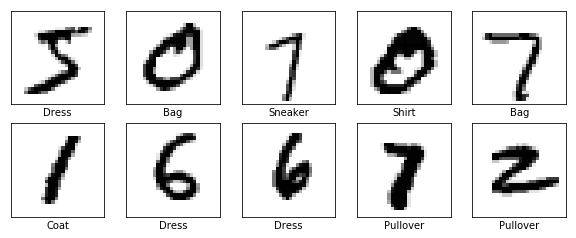

In [4]:
with tf.Session() as sess:
    plt.figure(figsize=(10,10))
    #sess.run(train_labels)
    #sess.run(train_data)
    
    for i in range(10):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        image = sess.run(train_data[i]).reshape(28,28)
        label = sess.run(train_labels[i])
        #print("image shape: {}, label {}".format(image.shape, label))
        plt.imshow(image, cmap=plt.cm.binary)
        plt.xlabel(class_names[label])
    plt.show()

#train_data = tf.cast(train_data, tf.float32)
#eval_data = tf.cast(eval_data, tf.float32)
#train_data = train_data.reshape(train_data.shape[0], train_data.shape[1]*train_data.shape[2])
#eval_data = eval_data.reshape(eval_data.shape[0], eval_data.shape[1]*eval_data.shape[2])

### 1.2 Estimator

#### 1.2.1 Model Function

In [5]:
LEARNING_RATE = 1e-4

def create_model(data_format):
    """Model to recognize digits in the MNIST dataset.
    Network structure is equivalent to:
    https://github.com/tensorflow/tensorflow/blob/r1.5/tensorflow/examples/tutorials/mnist/mnist_deep.py
    and
    https://github.com/tensorflow/models/blob/master/tutorials/image/mnist/convolutional.py
    But uses the tf.keras API.
    Args:
      data_format: Either 'channels_first' or 'channels_last'. 'channels_first' is
        typically faster on GPUs while 'channels_last' is typically faster on
        CPUs. See
        https://www.tensorflow.org/performance/performance_guide#data_formats
    Returns:
      A tf.keras.Model.
    """
  
    if data_format == 'channels_first':
        input_shape = [1, 28, 28]
    else:
        assert data_format == 'channels_last'
        input_shape = [28, 28, 1]

    
    l = tf.keras.layers
    max_pool = l.MaxPooling2D(
      (2, 2), (2, 2), padding='same', data_format=data_format)
  # The model consists of a sequential chain of layers, so tf.keras.Sequential
  # (a subclass of tf.keras.Model) makes for a compact description.
  
    return tf.keras.Sequential(
      [
          l.Reshape(
              target_shape=input_shape,
              input_shape=(28 * 28,)),
          l.Conv2D(
              32,
              5,
              padding='same',
              data_format=data_format,
              activation=tf.nn.relu),
          max_pool,
          l.Conv2D(
              64,
              5,
              padding='same',
              data_format=data_format,
              activation=tf.nn.relu),
          max_pool,
          l.Flatten(),
          l.Dense(512, activation=tf.nn.relu),
          l.Dropout(0.4),
          l.Dense(NUM_CLASSES)
      ])


In [6]:
def model_fn(features, labels, mode, params):
    """The model_fn argument for creating an Estimator."""

    print("params: {}".format(params))
    model = create_model(params['data_format'])
    image = features
    #pred_class = predictions['class_ids']
    
    if isinstance(image, dict):
        image = features['image']

    is_training = True if mode == tf.estimator.ModeKeys.TRAIN else False
         
    if mode == tf.estimator.ModeKeys.PREDICT:
        logits = model(image, training=False)
        predicted_classes = tf.argmax(logits, 1)
        predictions = {
            'class_ids': predicted_classes[:, tf.newaxis],
            'classes': tf.argmax(logits, axis=1),
            'probabilities': tf.nn.softmax(logits),
        }
        #predictions=pred_class
        return tf.estimator.EstimatorSpec(
            mode=tf.estimator.ModeKeys.PREDICT,
            predictions=predictions,
            export_outputs={
                'predict': tf.estimator.export.PredictOutput(predictions)
            })
  
    if mode == tf.estimator.ModeKeys.TRAIN:
        head = tf.contrib.estimator.multi_class_head(n_classes=NUM_CLASSES)   
        optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)

        logits = model(image, training=True)
        loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
        accuracy = tf.metrics.accuracy(
            labels=labels, predictions=tf.argmax(logits, axis=1))

    # Name tensors to be logged with LoggingTensorHook.
        tf.identity(LEARNING_RATE, 'learning_rate')
        tf.identity(loss, 'cross_entropy')
        tf.identity(accuracy[1], name='train_accuracy')

    # Save accuracy scalar to Tensorboard output.
        tf.summary.scalar('train_accuracy', accuracy[1])

        return tf.estimator.EstimatorSpec(
            mode=tf.estimator.ModeKeys.TRAIN,
            loss=loss,
            train_op=optimizer.minimize(loss, tf.train.get_or_create_global_step()))
    if mode == tf.estimator.ModeKeys.EVAL:
        logits = model(image, training=False)
        predicted_classes = tf.argmax(logits, 1)
        loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
        return tf.estimator.EstimatorSpec(
            mode=tf.estimator.ModeKeys.EVAL,
            loss=loss,
            eval_metric_ops={
                'accuracy':
                    tf.metrics.accuracy(
                        labels=labels, predictions=tf.argmax(logits, axis=1)),
                }
            )
    

### 1.3 Train and Evaluate

#### 1.3.1 Experiment Function

In [7]:
#def run_mnist(hparam, run_config):
def run_mnist(flags_obj):
    session_config = tf.ConfigProto(
      inter_op_parallelism_threads=flags_obj.inter_op_parallelism_threads,
      intra_op_parallelism_threads=flags_obj.intra_op_parallelism_threads,
      allow_soft_placement=True)

#    distribution_strategy = distribution_utils.get_distribution_strategy(
#      distribution_strategy=flags_obj.distribution_strategy,
#      num_gpus=flags_core.get_num_gpus(flags_obj),
#      all_reduce_alg=flags_obj.all_reduce_alg)

    run_config = tf.estimator.RunConfig(session_config=session_config)    
    model_function = model_fn    
    
    data_format = None
    if data_format is None:
        data_format = ('channels_first'
                   if tf.test.is_built_with_cuda() else 'channels_last')

    def _metric_fn(labels, predictions):

        metrics = {}
        pred_class = predictions['class_ids']
        metrics['micro_accuracy'] = tf.metrics.mean_per_class_accuracy(
            labels=labels, predictions=pred_class, num_classes=NUM_CLASSES
        )
    
    mnist_classifier = tf.estimator.Estimator(
      model_fn=model_function,
      model_dir=flags_obj.model_dir,
      config=run_config,
      params={
          'data_format': data_format,
          'learning_rate': LEARNING_RATE,
      })

    trainer = tf.contrib.estimator.add_metrics(
        estimator=mnist_classifier, metric_fn=_metric_fn)

    # Set up training and evaluation input functions.
    def train_input_fn():
        """Prepare data for training."""

        # When choosing shuffle buffer sizes, larger sizes result in better
        # randomness, while smaller sizes use less memory. MNIST is a small
        # enough dataset that we can easily shuffle the full epoch.
        ds = dataset.train(flags_obj.data_dir)
        ds = ds.cache().shuffle(buffer_size=50000).batch(flags_obj.batch_size)

        # Iterate through the dataset a set number (`epochs_between_evals`) of times
        # during each training session.
        ds = ds.repeat(flags_obj.epochs_between_evals)
        return ds

    def eval_input_fn():
        return dataset.test(flags_obj.data_dir).batch(
            flags_obj.batch_size).make_one_shot_iterator().get_next()    
    
    # Set up hook that outputs training logs every 100 steps.
    train_hooks = hooks_helper.get_train_hooks(
        flags_obj.hooks, model_dir=flags_obj.model_dir,
        batch_size=flags_obj.batch_size)

    # Train and evaluate model.
    tf.logging.set_verbosity(tf.logging.INFO)    
    time_start = datetime.utcnow() 
    print("Experiment started at {}".format(time_start.strftime("%H:%M:%S")))
    print(".......................................") 
    i = 0
    for _ in range(flags_obj.train_epochs // flags_obj.epochs_between_evals):
        
        trainer.train(input_fn=train_input_fn, hooks=train_hooks)
        
        eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
        
        print('\nEvaluation results:\n\t%s\n' % eval_results)

        if model_helpers.past_stop_threshold(flags_obj.stop_threshold,
                                         eval_results['accuracy']):
              break
        if i < 2:
            i = i + 1
        else:
            break
    time_end = datetime.utcnow() 
    print(".......................................")
    print("Experiment finished at {}".format(time_end.strftime("%H:%M:%S")))
    print("")
    time_elapsed = time_end - time_start
    print("Experiment elapsed time: {} seconds".format(time_elapsed.total_seconds()))    


    return trainer

#### 1.3.3 Run Experiment

In [8]:
def main(_):
    estimator = run_mnist(flags.FLAGS)
    
def define_mnist_flags():
    flags_core.define_base()
    flags_core.define_performance(num_parallel_calls=False)
    flags_core.define_image()
    flags.adopt_module_key_flags(flags_core)
    flags_core.set_defaults(data_dir=datadir,
                          model_dir=model_dir,
                          train_epochs=40)
    
define_mnist_flags()

if tf.gfile.Exists(model_dir):
    print("Removing previous artifacts...")
    tf.gfile.DeleteRecursively(model_dir)

sys.argv = "-f test".split(" ")
flags.FLAGS(sys.argv)
estimator = run_mnist(flags.FLAGS)
#absl_app.run(main)



Removing previous artifacts...


W0429 14:32:27.714735 30860 deprecation.py:323] From c:\users\steve\anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
I0429 14:32:27.757623 30860 estimator.py:1111] Calling model_fn.
I0429 14:32:27.758620 30860 estimator.py:1111] Calling model_fn.
W0429 14:32:27.861343 30860 deprecation.py:506] From c:\users\steve\anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\keras\layers\core.py:143: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Experiment started at 21:32:27
.......................................
params: {'data_format': 'channels_last', 'learning_rate': 0.0001}


W0429 14:32:27.951103 30860 deprecation.py:323] From c:\users\steve\anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\ops\losses\losses_impl.py:209: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
I0429 14:32:28.213438 30860 estimator.py:1113] Done calling model_fn.
I0429 14:32:28.214400 30860 estimator.py:1113] Done calling model_fn.
I0429 14:32:28.216395 30860 basic_session_run_hooks.py:527] Create CheckpointSaverHook.
I0429 14:32:28.469283 30860 monitored_session.py:222] Graph was finalized.
I0429 14:32:28.693714 30860 session_manager.py:491] Running local_init_op.
I0429 14:32:28.706651 30860 session_manager.py:493] Done running local_init_op.
I0429 14:32:28.958017 30860 basic_session_run_hooks.py:594] Saving checkpoints for 0 into models\mnist\cnn_classifier\model.ckpt.
I0429 14:32:30.817341 30860 basic_session_run_hooks.py:249] cross_entropy = 2.3079066, learning_rate 

params: {'data_format': 'channels_last', 'learning_rate': 0.0001}


I0429 14:34:26.572759 30860 monitored_session.py:222] Graph was finalized.
W0429 14:34:26.574757 30860 deprecation.py:323] From c:\users\steve\anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
I0429 14:34:26.578743 30860 saver.py:1270] Restoring parameters from models\mnist\cnn_classifier\model.ckpt-1875
I0429 14:34:26.626615 30860 session_manager.py:491] Running local_init_op.
I0429 14:34:26.637586 30860 session_manager.py:493] Done running local_init_op.
I0429 14:34:31.910488 30860 evaluation.py:277] Finished evaluation at 2019-04-29-21:34:31
I0429 14:34:31.911485 30860 estimator.py:1979] Saving dict for global step 1875: accuracy = 0.9738, global_step = 1875, loss = 0.081925295
I0429 14:34:31.961157 30860 estimator.py:2039] Saving 'che


Evaluation results:
	{'loss': 0.081925295, 'accuracy': 0.9738, 'global_step': 1875}

params: {'data_format': 'channels_last', 'learning_rate': 0.0001}


I0429 14:34:32.395261 30860 estimator.py:1113] Done calling model_fn.
I0429 14:34:32.396226 30860 estimator.py:1113] Done calling model_fn.
I0429 14:34:32.397223 30860 basic_session_run_hooks.py:527] Create CheckpointSaverHook.
I0429 14:34:32.499981 30860 monitored_session.py:222] Graph was finalized.
I0429 14:34:32.505966 30860 saver.py:1270] Restoring parameters from models\mnist\cnn_classifier\model.ckpt-1875
W0429 14:34:32.574750 30860 deprecation.py:323] From c:\users\steve\anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py:1070: get_checkpoint_mtimes (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file utilities to get mtimes.
I0429 14:34:32.606666 30860 session_manager.py:491] Running local_init_op.
I0429 14:34:32.620640 30860 session_manager.py:493] Done running local_init_op.
I0429 14:34:32.863263 30860 basic_session_run_hooks.py:594] Saving check

params: {'data_format': 'channels_last', 'learning_rate': 0.0001}


I0429 14:36:36.209395 30860 monitored_session.py:222] Graph was finalized.
I0429 14:36:36.214381 30860 saver.py:1270] Restoring parameters from models\mnist\cnn_classifier\model.ckpt-3750
I0429 14:36:36.264247 30860 session_manager.py:491] Running local_init_op.
I0429 14:36:36.277213 30860 session_manager.py:493] Done running local_init_op.
I0429 14:36:41.627777 30860 evaluation.py:277] Finished evaluation at 2019-04-29-21:36:41
I0429 14:36:41.628774 30860 estimator.py:1979] Saving dict for global step 3750: accuracy = 0.9854, global_step = 3750, loss = 0.046649855
I0429 14:36:41.632764 30860 estimator.py:2039] Saving 'checkpoint_path' summary for global step 3750: models\mnist\cnn_classifier\model.ckpt-3750
I0429 14:36:41.694599 30860 estimator.py:1111] Calling model_fn.
I0429 14:36:41.695597 30860 estimator.py:1111] Calling model_fn.



Evaluation results:
	{'loss': 0.046649855, 'accuracy': 0.9854, 'global_step': 3750}

params: {'data_format': 'channels_last', 'learning_rate': 0.0001}


I0429 14:36:42.138412 30860 estimator.py:1113] Done calling model_fn.
I0429 14:36:42.139411 30860 estimator.py:1113] Done calling model_fn.
I0429 14:36:42.141451 30860 basic_session_run_hooks.py:527] Create CheckpointSaverHook.
I0429 14:36:42.244160 30860 monitored_session.py:222] Graph was finalized.
I0429 14:36:42.250113 30860 saver.py:1270] Restoring parameters from models\mnist\cnn_classifier\model.ckpt-3750
I0429 14:36:42.350845 30860 session_manager.py:491] Running local_init_op.
I0429 14:36:42.362812 30860 session_manager.py:493] Done running local_init_op.
I0429 14:36:42.604201 30860 basic_session_run_hooks.py:594] Saving checkpoints for 3750 into models\mnist\cnn_classifier\model.ckpt.
I0429 14:36:44.156297 30860 basic_session_run_hooks.py:249] cross_entropy = 0.26721984, learning_rate = 1e-04, train_accuracy = 0.9375
I0429 14:36:44.158292 30860 basic_session_run_hooks.py:249] loss = 0.26721984, step = 3751
I0429 14:36:50.738698 30860 basic_session_run_hooks.py:680] global_ste

params: {'data_format': 'channels_last', 'learning_rate': 0.0001}


I0429 14:38:51.839655 30860 monitored_session.py:222] Graph was finalized.
I0429 14:38:51.843614 30860 saver.py:1270] Restoring parameters from models\mnist\cnn_classifier\model.ckpt-5625
I0429 14:38:51.893481 30860 session_manager.py:491] Running local_init_op.
I0429 14:38:51.904473 30860 session_manager.py:493] Done running local_init_op.
I0429 14:38:57.276114 30860 evaluation.py:277] Finished evaluation at 2019-04-29-21:38:57
I0429 14:38:57.277112 30860 estimator.py:1979] Saving dict for global step 5625: accuracy = 0.988, global_step = 5625, loss = 0.03834198
I0429 14:38:57.279107 30860 estimator.py:2039] Saving 'checkpoint_path' summary for global step 5625: models\mnist\cnn_classifier\model.ckpt-5625



Evaluation results:
	{'loss': 0.03834198, 'accuracy': 0.988, 'global_step': 5625}

.......................................
Experiment finished at 21:38:57

Experiment elapsed time: 389.570325 seconds


estimator = run_experiment(hparams, run_config)
### 1.4 Export the model

In [9]:
export_dir = os.path.join(model_dir, 'export')
    
if tf.gfile.Exists(export_dir):
    tf.gfile.DeleteRecursively(export_dir)
#inputs = {'image': tf.placeholder(shape=[None,784], dtype=tf.float32, name='image')}    
image = tf.placeholder(tf.float32, [None, 28, 28], name='image')
input_fn = tf.estimator.export.build_raw_serving_input_receiver_fn({
        'image': image,
    })
estimator.export_savedmodel(export_dir_base=export_dir, 
                            serving_input_receiver_fn=input_fn)
        


I0429 14:43:13.434261 30860 estimator.py:1111] Calling model_fn.
I0429 14:43:13.434261 30860 estimator.py:1111] Calling model_fn.
I0429 14:43:13.594059 30860 estimator.py:1113] Done calling model_fn.
I0429 14:43:13.596056 30860 estimator.py:1113] Done calling model_fn.
W0429 14:43:13.600049 30860 deprecation.py:323] From c:\users\steve\anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\saved_model\signature_def_utils_impl.py:205: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
I0429 14:43:13.604032 30860 export.py:587] Signatures INCLUDED in export for Eval: None
I0429 14:43:13.607023 30860 export.py:587] Signatures INCLUDED in export for Classify: None
I0429 14:43:13.607023 30860 export.py:587] Signatures 

params: {'data_format': 'channels_last', 'learning_rate': 0.0001}


I0429 14:43:13.645926 30860 saver.py:1270] Restoring parameters from models\mnist\cnn_classifier\model.ckpt-5625
I0429 14:43:13.690800 30860 builder_impl.py:654] Assets added to graph.
I0429 14:43:13.691836 30860 builder_impl.py:449] No assets to write.
I0429 14:43:13.784546 30860 builder_impl.py:414] SavedModel written to: models\mnist\cnn_classifier\export\temp-b'1556574193'\saved_model.pb


b'models\\mnist\\cnn_classifier\\export\\1556574193'

## 2. Inspect the Exported SavedModel

In [10]:
%%bash

saved_models_base=models/mnist/cnn_classifier/export/
saved_model_dir=${saved_models_base}$(ls ${saved_models_base} | tail -n 1)
echo ${saved_model_dir}
ls ${saved_model_dir}
saved_model_cli show --dir=${saved_model_dir} --all

models/mnist/cnn_classifier/export/1556574193
saved_model.pb
variables

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['predict']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['image'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28)
        name: image:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['class_ids'] tensor_info:
        dtype: DT_INT64
        shape: (-1, 1)
        name: strided_slice:0
    outputs['classes'] tensor_info:
        dtype: DT_INT64
        shape: (-1)
        name: ArgMax_1:0
    outputs['probabilities'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: Softmax:0
  Method name is: tensorflow/serving/predict

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['image'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28)
        name: 

### Prediction with SavedModel

In [11]:
def inference_test(saved_model_dir, signature="predict", input_name='image', batch_size=300, repeat=100):

#    es = dataset.test(datadir)
#    iter = images.make_one_shot_iterator()
    #print ("Eval data shape: {}".format(eval_data.shape))
#    eval_data, eval_labels = iter.get_next()
    tf.logging.set_verbosity(tf.logging.ERROR)
    
    time_start = datetime.utcnow() 
    
    predictor = tf.contrib.predictor.from_saved_model(
        export_dir = saved_model_dir,
        signature_def_key=signature
    )
    time_end = datetime.utcnow() 
        
    time_elapsed = time_end - time_start
   
    print ("")
    print("Model loading time: {} seconds".format(time_elapsed.total_seconds()))
    print ("")
    
    time_start = datetime.utcnow() 
    output = None
    def eval_input_fn():
        return dataset.test(datadir).batch(
            batch_size).make_one_shot_iterator().get_next()       
    
    with tf.Session() as sess:
        for i in range(repeat):
            input_images, labels = sess.run(eval_input_fn())        
            #print(input_images[0])
            input_images = input_images.reshape(batch_size, 28,28)
            output = predictor(
                {
                    input_name: input_images
                }
            )
    
    time_end = datetime.utcnow() 

    time_elapsed_sec = (time_end - time_start).total_seconds()
    
    print ("Inference elapsed time: {} seconds".format(time_elapsed_sec))
    print ("")
    
    print ("Prediction produced for {} instances batch, repeated {} times".format(len(output['class_ids']), repeat))
    print ("Average latency per batch: {} seconds".format(time_elapsed_sec/repeat))
    print ("")
    
    print ("Prediction output for the last instance:")
    for key in output.keys():
        print ("{}: {}".format(key,output[key][0]))

## 3. Test Prediction with SavedModel 

In [12]:
saved_model_dir = os.path.join(export_dir, os.listdir(export_dir)[-1]) 
print(saved_model_dir)
inference_test(saved_model_dir)

models\mnist\cnn_classifier\export\1556574193

Model loading time: 0.080784 seconds

Inference elapsed time: 33.139615 seconds

Prediction produced for 300 instances batch, repeated 100 times
Average latency per batch: 0.33139615 seconds

Prediction output for the last instance:
probabilities: [3.9680742e-07 1.2645016e-06 8.4969024e-06 1.2876747e-04 2.4702018e-09
 5.6581194e-07 7.7370957e-11 9.9983215e-01 1.2599568e-07 2.8207556e-05]
classes: 7
class_ids: [7]


### Describe GraphDef

In [13]:
def describe_graph(graph_def, show_nodes=False):
    
    print ('Input Feature Nodes: {}'.format([node.name for node in graph_def.node if node.op=='Placeholder']))
    print ("")
    print ('Unused Nodes: {}'.format([node.name for node in graph_def.node if 'unused'  in node.name]))
    print ("")
    print ('Output Nodes: {}'.format( [node.name for node in graph_def.node if 'predictions' in node.name]))
    print ("")
    print ('Quanitization Nodes: {}'.format( [node.name for node in graph_def.node if 'quant' in node.name]))
    print ("")
    print ('Constant Count: {}'.format( len([node for node in graph_def.node if node.op=='Const'])))
    print ("")
    print ('Variable Count: {}'.format( len([node for node in graph_def.node if 'Variable' in node.op])))
    print ("")
    print ('Identity Count: {}'.format( len([node for node in graph_def.node if node.op=='Identity'])))
    print ("")
    print ('Total nodes: {}'.format( len(graph_def.node)))
    print ('')
    node_names = [node.name for node in graph_def.node if node.op=='Identity']
    print(node_names)

    if show_nodes==True:
        for node in graph_def.node:
            print ('Op:{} - Name: {}'.format(node.op, node.name))

## 4. Describe the SavedModel Graph (before optimisation)

### Load GraphDef from a SavedModel Directory

In [14]:
def get_graph_def_from_saved_model(saved_model_dir):
    
    print (saved_model_dir)
    print ("")
    
    from tensorflow.python.saved_model import tag_constants
    
    with tf.Session() as session:
        meta_graph_def = tf.saved_model.loader.load(
            session,
            tags=[tag_constants.SERVING],
            export_dir=saved_model_dir
        )
        
    return meta_graph_def.graph_def

In [16]:
describe_graph(get_graph_def_from_saved_model(saved_model_dir))

models\mnist\cnn_classifier\export\1556574193

Input Feature Nodes: ['image', 'reshape_input']

Unused Nodes: []

Output Nodes: []

Quanitization Nodes: []

Constant Count: 57

Variable Count: 41

Identity Count: 16

Total nodes: 225

['global_step/read', 'dropout/cond/switch_t', 'dropout/cond/switch_f', 'dropout/cond/pred_id', 'dropout/cond/Identity', 'sequential/dropout/Identity', 'save/control_dependency', 'save/Identity', 'save/Identity_1', 'save/Identity_2', 'save/Identity_3', 'save/Identity_4', 'save/Identity_5', 'save/Identity_6', 'save/Identity_7', 'save/Identity_8']


### Get model size

In [17]:
def get_size(model_dir):
    
    print (model_dir)
    print ("")
    
    pb_size = os.path.getsize(os.path.join(model_dir,'saved_model.pb'))
    
    variables_size = 0
    if os.path.exists(os.path.join(model_dir,'variables/variables.data-00000-of-00001')):
        variables_size = os.path.getsize(os.path.join(model_dir,'variables/variables.data-00000-of-00001'))
        variables_size += os.path.getsize(os.path.join(model_dir,'variables/variables.index'))

    print ("Model size: {} KB".format(round(pb_size/(1024.0),3)))
    print ("Variables size: {} KB".format(round( variables_size/(1024.0),3)))
    print ("Total Size: {} KB".format(round((pb_size + variables_size)/(1024.0),3)))
    

In [18]:
get_size(saved_model_dir)

models\mnist\cnn_classifier\export\1556574193

Model size: 38.92 KB
Variables size: 6497.947 KB
Total Size: 6536.867 KB


## 5. Freeze SavedModel

This function will convert the SavedModel into a GraphDef file (freezed_model.pb), and storing the variables as constrant to the freezed_model.pb

You need to define the graph output nodes for freezing. We are only interested in the **class_id**, which is produced by **head/predictions/ExpandDims** node

In [19]:
def freeze_graph(saved_model_dir):
    
    from tensorflow.python.tools import freeze_graph
    from tensorflow.python.saved_model import tag_constants
    
    output_graph_filename = os.path.join(saved_model_dir, "freezed_model.pb")
#    output_node_names = "head/predictions/ExpandDims"
#    output_node_names = "PREDICT/predictions/probabilities"
    output_node_names = "strided_slice"
    
    initializer_nodes = ""

    freeze_graph.freeze_graph(
        input_saved_model_dir=saved_model_dir,
        output_graph=output_graph_filename,
        saved_model_tags = tag_constants.SERVING,
        output_node_names=output_node_names,
        initializer_nodes=initializer_nodes,

        input_graph=None, 
        input_saver=False,
        input_binary=False, 
        input_checkpoint=None, 
        restore_op_name=None, 
        filename_tensor_name=None, 
        clear_devices=False,
        input_meta_graph=False,
    )
    
    print ("SavedModel graph freezed!")

In [20]:
node_names = [node.name for node in tf.get_default_graph().as_graph_def().node]

freeze_graph(saved_model_dir)

SavedModel graph freezed!


In [21]:
%%bash
saved_models_base=models/mnist/cnn_classifier/export/
saved_model_dir=${saved_models_base}$(ls ${saved_models_base} | tail -n 1)
echo ${saved_model_dir}
ls ${saved_model_dir}

models/mnist/cnn_classifier/export/1556574193
freezed_model.pb
saved_model.pb
variables


## 6. Describe the freezed_model.pb Graph (after freezing)

### Load GraphDef from GraphDef File

In [22]:
def get_graph_def_from_file(graph_filepath):
    
    print (graph_filepath)
    print ("")
    
    from tensorflow.python import ops
    
    with ops.Graph().as_default():
        with tf.gfile.GFile(graph_filepath, "rb") as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
            
            return graph_def
            

In [24]:
freezed_filepath=os.path.join(saved_model_dir,'freezed_model.pb')
describe_graph(get_graph_def_from_file(freezed_filepath))

models\mnist\cnn_classifier\export\1556574193\freezed_model.pb

Input Feature Nodes: ['image']

Unused Nodes: []

Output Nodes: []

Quanitization Nodes: []

Constant Count: 22

Variable Count: 0

Identity Count: 9

Total nodes: 55

['sequential/conv2d/Conv2D/ReadVariableOp', 'sequential/conv2d/BiasAdd/ReadVariableOp', 'sequential/conv2d_1/Conv2D/ReadVariableOp', 'sequential/conv2d_1/BiasAdd/ReadVariableOp', 'sequential/dense/MatMul/ReadVariableOp', 'sequential/dense/BiasAdd/ReadVariableOp', 'sequential/dropout/Identity', 'sequential/dense_1/MatMul/ReadVariableOp', 'sequential/dense_1/BiasAdd/ReadVariableOp']


## 8. Optimise the freezed_model.pb

### Optimise GraphDef

In [25]:
def optimize_graph(model_dir, graph_filename, transforms):
    
    from tensorflow.tools.graph_transforms import TransformGraph
    
    input_names = []
#    output_names = ['head/predictions/ExpandDims']
    output_names = ['strided_slice']
    
    graph_def = get_graph_def_from_file(os.path.join(model_dir, graph_filename))
    optimised_graph_def = TransformGraph(graph_def, 
                                         input_names,
                                         output_names,
                                         transforms 
                                        )
    tf.train.write_graph(optimised_graph_def,
                        logdir=model_dir,
                        as_text=False,
                        name='optimised_model.pb')
    
    print ("Freezed graph optimised!")

In [26]:
transforms = [
    'remove_nodes(op=Identity)', 
    'fold_constants(ignore_errors=true)',
    'fold_batch_norms',
#    'fuse_resize_pad_and_conv',
#    'quantize_weights',
#    'quantize_nodes',
    'merge_duplicate_nodes',
    'strip_unused_nodes', 
    'sort_by_execution_order'
]

optimize_graph(saved_model_dir, 'freezed_model.pb', transforms)

models\mnist\cnn_classifier\export\1556574193\freezed_model.pb

Freezed graph optimised!


In [27]:
%%bash
saved_models_base=models/mnist/cnn_classifier/export/
saved_model_dir=${saved_models_base}$(ls ${saved_models_base} | tail -n 1)
echo ${saved_model_dir}
ls ${saved_model_dir}

models/mnist/cnn_classifier/export/1556574193
freezed_model.pb
optimised_model.pb
saved_model.pb
variables


## 8. Describe the Optimised Graph

In [28]:
optimised_filepath=os.path.join(saved_model_dir,'optimised_model.pb')
describe_graph(get_graph_def_from_file(optimised_filepath))

models\mnist\cnn_classifier\export\1556574193\optimised_model.pb

Input Feature Nodes: ['image']

Unused Nodes: []

Output Nodes: []

Quanitization Nodes: []

Constant Count: 15

Variable Count: 0

Identity Count: 0

Total nodes: 39

[]


## 9. Convert Optimised graph (GraphDef) to SavedModel

In [27]:
def convert_graph_def_to_saved_model(graph_filepath):

    from tensorflow.python import ops
    export_dir=os.path.join(saved_model_dir,'optimised')

    if tf.gfile.Exists(export_dir):
        tf.gfile.DeleteRecursively(export_dir)

    graph_def = get_graph_def_from_file(graph_filepath)
    
    with tf.Session(graph=tf.Graph()) as session:
        tf.import_graph_def(graph_def, name="")
        tf.saved_model.simple_save(session,
                export_dir,
                inputs={
                    node.name: session.graph.get_tensor_by_name("{}:0".format(node.name)) 
                    for node in graph_def.node if node.op=='Placeholder'},
                outputs={
                    "class_ids": session.graph.get_tensor_by_name("strided_slice:0"),
                }
            )

        print ("Optimised graph converted to SavedModel!")

In [28]:
optimised_filepath=os.path.join(saved_model_dir,'optimised_model.pb')
convert_graph_def_to_saved_model(optimised_filepath)

models\mnist\cnn_classifier\export\1556558269\optimised_model.pb

Optimised graph converted to SavedModel!


### Optimised SavedModel Size

In [29]:
optimised_saved_model_dir = os.path.join(saved_model_dir,'optimised') 
get_size(optimised_saved_model_dir)

models\mnist\cnn_classifier\export\1556558269\optimised

Model size: 12799.12 KB
Variables size: 0.0 KB
Total Size: 12799.12 KB


In [30]:
%%bash

saved_models_base=models/mnist/cnn_classifier/export/
saved_model_dir=${saved_models_base}$(ls ${saved_models_base} | tail -n 1)/optimised
ls ${saved_model_dir}
saved_model_cli show --dir ${saved_model_dir} --all

saved_model.pb
variables

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['image'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28)
        name: image:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['class_ids'] tensor_info:
        dtype: DT_INT64
        shape: (-1, 1)
        name: strided_slice:0
  Method name is: tensorflow/serving/predict


## 10. Prediction with the Optimised SavedModel

In [31]:
optimised_saved_model_dir = os.path.join(saved_model_dir,'optimised') 
print(optimised_saved_model_dir)
inference_test(saved_model_dir=optimised_saved_model_dir, signature='serving_default', input_name='image')

models\mnist\cnn_classifier\export\1556558269\optimised

Model loading time: 0.163525 seconds

Inference elapsed time: 71.615196 seconds

Prediction produced for 300 instances batch, repeated 100 times
Average latency per batch: 0.7161519599999999 seconds

Prediction output for the last instance:
class_ids: [7]


# Cloud ML Engine Deployment and Prediction

In [32]:
PROJECT = 'steven-wang-playground'
BUCKET = 'steven-gcs-cloudml'
REGION = 'europe-west1'
MODEL_NAME = 'mnist_classifier'

os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION
os.environ['MODEL_NAME'] = MODEL_NAME

## 1. Upload the model artefacts to Google Cloud Storage bucket

In [ ]:
%%bash

gsutil -m rm -r gs://${BUCKET}/tf-model-optimisation

In [ ]:
%%bash

saved_models_base=models/mnist/cnn_classifier/export/
saved_model_dir=${saved_models_base}$(ls ${saved_models_base} | tail -n 1)

echo ${saved_model_dir}

gsutil -m cp -r ${saved_model_dir} gs://${BUCKET}/tf-model-optimisation/original

In [ ]:
%%bash

saved_models_base=models/mnist/cnn_classifier/export/
saved_model_dir=${saved_models_base}$(ls ${saved_models_base} | tail -n 1)/optimised

echo ${saved_model_dir}

gsutil -m cp -r ${saved_model_dir} gs://${BUCKET}/tf-model-optimisation

## 2. Deploy models to Cloud ML Engine

Don't forget to delete the model and the model version if they were previously deployed!

In [ ]:
%%bash

echo ${MODEL_NAME}

gcloud ml-engine models create ${MODEL_NAME} --regions=${REGION}

**Version: v_org** is the original SavedModel (before optimisation)

In [ ]:
%%bash

MODEL_VERSION='v_org'
MODEL_ORIGIN=gs://${BUCKET}/tf-model-optimisation/original

gcloud ml-engine versions create ${MODEL_VERSION}\
            --model=${MODEL_NAME} \
            --origin=${MODEL_ORIGIN} \
            --runtime-version=1.10

**Version: v_opt** is the optimised SavedModel (after optimisation)

In [ ]:
%%bash

MODEL_VERSION='v_opt'
MODEL_ORIGIN=gs://${BUCKET}/tf-model-optimisation/optimised

gcloud ml-engine versions create ${MODEL_VERSION}\
            --model=${MODEL_NAME} \
            --origin=${MODEL_ORIGIN} \
            --runtime-version=1.10

## 3. Cloud ML Engine online predictions

In [ ]:
from googleapiclient import discovery
from oauth2client.client import GoogleCredentials

credentials = GoogleCredentials.get_application_default()
api = discovery.build(
    'ml', 'v1', 
    credentials=credentials, 
    discoveryServiceUrl='https://storage.googleapis.com/cloud-ml/discovery/ml_v1_discovery.json'
)

    
def predict(version, instances):

    request_data = {'instances': instances}

    model_url = 'projects/{}/models/{}/versions/{}'.format(PROJECT, MODEL_NAME, version)
    response = api.projects().predict(body=request_data, name=model_url).execute()

    class_ids = None
    
    try:
        class_ids = [item["class_ids"] for item in response["predictions"]]
    except:
        print response
    
    return class_ids

In [ ]:
def inference_cmle(version, batch=100, repeat=10):
    
    instances = [
            {'input_image': [float(i) for i in list(eval_data[img])] }
        for img in range(batch)
    ]

    #warmup request
    predict(version, instances[0])
    print 'Warm up request performed!'
    print 'Timer started...'
    print ''
    
    time_start = datetime.utcnow() 
    output = None
    
    for i in range(repeat):
        output = predict(version, instances)
    
    time_end = datetime.utcnow() 

    time_elapsed_sec = (time_end - time_start).total_seconds()
    
    print "Inference elapsed time: {} seconds".format(time_elapsed_sec)
    print ""
    
    print "Prediction produced for {} instances batch, repeated {} times".format(len(output), repeat)
    print "Average latency per batch: {} seconds".format(time_elapsed_sec/repeat)
    print ""
    
    print "Prediction output for the last instance: {}".format(output[0])


In [ ]:
version='v_org'
inference_cmle(version)

In [ ]:
version='v_opt'
inference_cmle(version)

## Happy serving!